# Interaction Estimates
In this notebook we estimate the interaction strength uisng pairwise growth experiments The first step is to consider the growth of two species decribed by comeptitive Lotka volttera equations:

\begin{align}
    \frac{dC_1}{dt} &= C_1 (r_1 - a_{11}C_1 + \alpha C_2)
    \\
    \frac{dC_2}{dt} &= C_2 (r_2 - a_{22}C_2 + \alpha C_1)
\end{align}
 
assuming that interactions are symmetrical $a_{12} = a_{21} = \alpha$. These equations have the (non-trivial) solutions:

\begin{align*}
    {C_1}^* &= \frac{a_{22} r_{1} + \alpha r_{2}}{a_{11} a_{22} - \alpha^{2}} 
\\
    {C_2}^* &= \frac{a_{11} r_{2} + \alpha r_{1}}{a_{11} a_{22} - \alpha^{2}}
\end{align*}

Next we use these solutions to obtain an estimate of the total biomass in the system $C_{tot}^* = {C_1}^* + {C_2}^*$ which we can set equal to the observed final biomass from the pairwise experiments (denoted here as $K_{tot}$). This gives an expression for $\alpha$:

$$
K_{tot} \alpha^{2} + \alpha \left(r_{1} + r_{2}\right)- K_{tot} a_{11} a_{22} + a_{11} r_{2} + a_{22} r_{1} = 0
$$ 

which as a quadratic has solutions at:

\begin{align}
\frac{-b \pm \sqrt{b^2 - 4ac}}{2a} \quad \text{where} \quad \begin{array} 
    aa &= K_{tot}, \\
    b &= \left(r_{1} + r_{2}\right) \  \text{and} \\
    c &= -K_{tot} a_{11} a_{22} + a_{11} r_{2} + a_{22} r_{1}
    \end{array}
\end{align}

Thus giving two possible answers for $\alpha$. 

## Feasabilty
We can screen between these two values by considering their feasabiltiy (i.e. whether species have postive biomass). This can be calculated simplfy by calculating the biomasses as described above and ensuring they are both above 0:

\begin{align*}
    \frac{a_{22} r_{1} + \alpha r_{2}}{a_{11} a_{22} - \alpha^{2}} > 0 \quad \text{and} \quad
    \frac{a_{11} r_{2} + \alpha r_{1}}{a_{11} a_{22} - \alpha^{2}} > 0
\end{align*}


# Calculating

In [2]:
library(tidyverse)
library(broom)
library(nls.multstart)
library(cowplot)
library(gridExtra)
library(lme4)
library(lmerTest)
library(MuMIn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




# Fit Growth Curves

### Read Data

In [3]:
#read data in
grw_df <- read_csv(file= "../data/interactions/Pairwise_M9_Experiment.csv",col_type = cols()) %>%
    pivot_longer(-Reading,names_to = "ID", values_to = "OD") %>%
    separate(ID,into = c("ID","Treatment","Replicate"),sep = "_")

## correct data using average blank
Blank <- mean(grw_df$OD[which(grw_df$Treatment == "Blank")])
grw_df$OD_corrected <- grw_df$OD - Blank
grw_df <- grw_df[-which(grw_df$Treatment == "Blank"),]

## rename columns
names(grw_df) <- c("Time","Id", "Treatment", "Replicate", "OD","ODc")
#set negative values to 0
grw_df$ODc[which(grw_df$ODc<0)] <- 0

In [4]:
## load outliers dataframe
Out <- read.table("../data//interactions//all_outliers.csv", header = TRUE, sep = ",")

#generate_outliers code
code_out <- paste(Out$t,Out$pa,sep="-") %>%
    str_replace_all(., regex("[:-]"),"_") %>%
    str_replace_all(., fixed("."), "/")

grw_df <- grw_df %>% 
    mutate(code = paste(Time,Id,Treatment,Replicate, sep = "_")) %>%
    mutate(outlier = code %in% code_out)

grw_df$ODc[which(grw_df$Id == "15.18_NE" & grw_df$Time > 24)] <- NA
grw_df$ODc[which(grw_df$Id == "18_NE" & grw_df$Time > 32)] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Time > 38)] <- NA
grw_df$ODc[which(grw_df$Id == "20_NE" & grw_df$Time > 24)] <- NA
grw_df$ODc[which(grw_df$Id == "20.23_E" & grw_df$Time > 48)] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Replicate == "R2")] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Replicate == "R3")] <- NA
grw_df$ODc[which(grw_df$Id == "20_E" & grw_df$Replicate == "R5" & grw_df$Time < 17)] <- NA

In [6]:
#remove outliers and add id column
grw_df <- grw_df %>%
    filter(!outlier) %>%
    mutate(curve_Id = paste(Id,Treatment,Replicate, sep = "_"),
          ODc_log10 = log10(ODc)) %>%
    as.data.frame()

In [5]:
## Fit growth models 
logistic <- function(r,K,t,N0){
    K / (1 + ( (K-N0)/N0) * exp(-r*t))
}

#fit with NLS
start_up_bounds <- c(r = 2,   K = 4, N0 = 0.006)
start_low_bounds <- c(r = 0.1, K = 0, N0 = 0.001)
low <- c(r = 0.1, K = 0, N0 = 0.0)
up <- c(r = 4, K = 1, N0 = 0.1)

log_fits <- grw_df %>%
    group_by(Id,Treatment,Replicate) %>%
    nest() %>%
    mutate(logistic_fit = purrr::map(data, ~ nls_multstart(ODc ~ logistic(r,K, N0,t = Time),
                                    data = .x, iter = 500,
                                    start_lower = start_low_bounds, start_upper = start_up_bounds,
                                    supp_errors = "Y", na.action = na.omit,
                                    lower = low, upper = up)))

In [6]:
#compare predictions
#get nls_fits
params_log <- log_fits %>%
    mutate(params = map(logistic_fit,tidy)) %>%
    unnest(params) %>%
    select(Id,Treatment,Replicate,term,estimate) %>%
    group_by(term) %>% mutate(row = row_number()) %>%
    pivot_wider(names_from = term, values_from = estimate) %>%
    select(ID = Id,Treatment,Replicate,K,r) %>%
    mutate(aii = r / K)

head(params_log)

ID,Treatment,Replicate,K,r,aii
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2/15,NE,R1,0.1734509,0.1,0.5765320
2/15,NE,R2,0.1775747,0.1,0.5631434
2/15,NE,R3,0.1855382,0.1,0.5389725
2/15,NE,R4,0.1769375,0.1,0.5651714
2/15,NE,R5,0.1813144,0.1,0.5515282
2/15,NE,R6,0.1886708,0.1,0.5300236


In [13]:
log_fits %>%
    mutate(params = map(logistic_fit,tidy)) %>%
    unnest(params) %>%
    filter(term == "K") %>%
    select(-data,-logistic_fit) %>%
    arrange(desc(std.error))

Id,Treatment,Replicate,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
20,NE,R3,K,1.0000000,0.28595679,3.497032,8.536605e-04
20/23,E,R6,K,1.0000000,0.17381421,5.753269,2.559923e-07
23,NE,R1,K,0.5987301,0.06080875,9.846118,1.644889e-14
23,NE,R4,K,0.7515093,0.05832278,12.885349,1.456724e-19
23,NE,R5,K,0.7305128,0.05182991,14.094426,1.946773e-21
23,NE,R3,K,0.7523355,0.04929988,15.260392,3.621075e-23
20,NE,R4,K,0.4986247,0.03852434,12.943108,1.180336e-19
20/23,E,R1,K,1.0000000,0.03015229,33.164979,1.866422e-42
23,NE,R6,K,0.6292543,0.02678254,23.494948,1.787947e-33


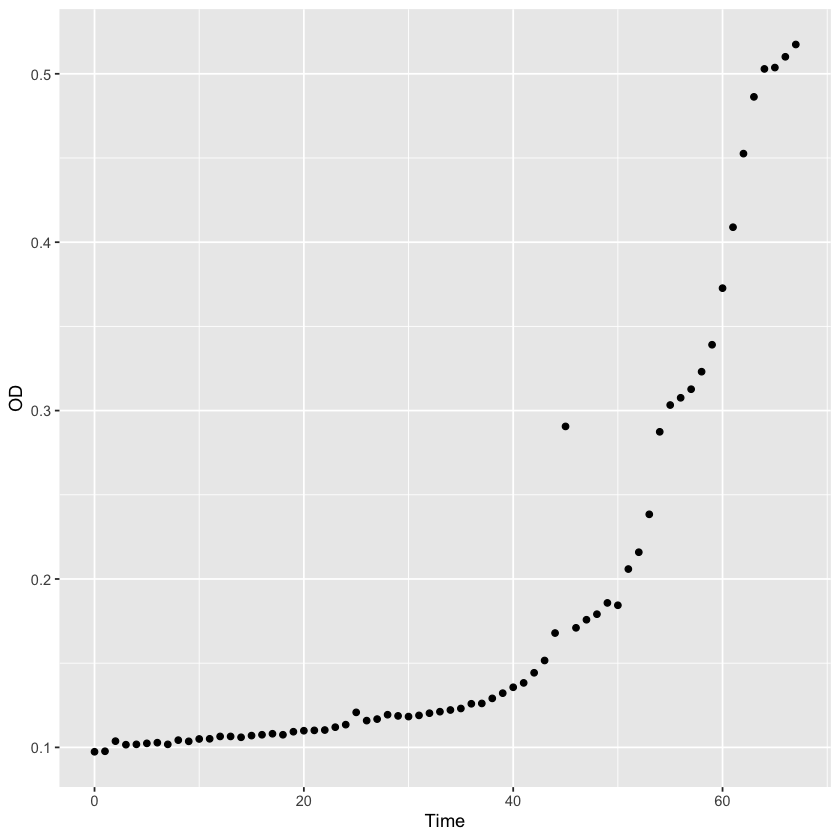

In [19]:
grw_df %>%
    filter(Id == "20", Treatment == "NE", Replicate == "R3") %>%
        ggplot(aes(x=Time,y=OD))+
            geom_point()

In [97]:
#compare predictions
#get nls_fits
params_log <- model_fits_2 %>%
    mutate(params = map(fit,tidy)) %>%
    unnest(params) %>%
    select(Id, Treatment, Replicate, term, estimate, std.error, p.value) %>%
    filter(term == "r")
    
# group_by(term) %>% mutate(row = row_number()) %>%
    # pivot_wider(names_from = term, values_from = estimate) %>%
    # select(ID = Id,Treatment,Replicate,K,r) %>%
    # mutate(aii = r / K)

head(params_log, n = 5)

Id,Treatment,Replicate,term,estimate,std.error,p.value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2/15,NE,R1,r,0.2859404,0.03604544,4.093561e-07
2/15,NE,R2,r,0.2741523,0.03290990,2.094648e-07
2/15,NE,R3,r,0.2738740,0.03657565,8.876819e-07
2/15,NE,R4,r,0.3022637,0.03566375,1.648799e-07
2/15,NE,R5,r,0.2814372,0.03299732,1.509888e-07


In [98]:
df_pair <- params_log %>%
    filter(str_detect(Id, fixed("/"))) %>%
    separate(Id, into = c("OTU_1","OTU_2"),sep = "/", remove = F)

df_sp <- params_log %>%
    filter(!str_detect(Id, fixed("/")))

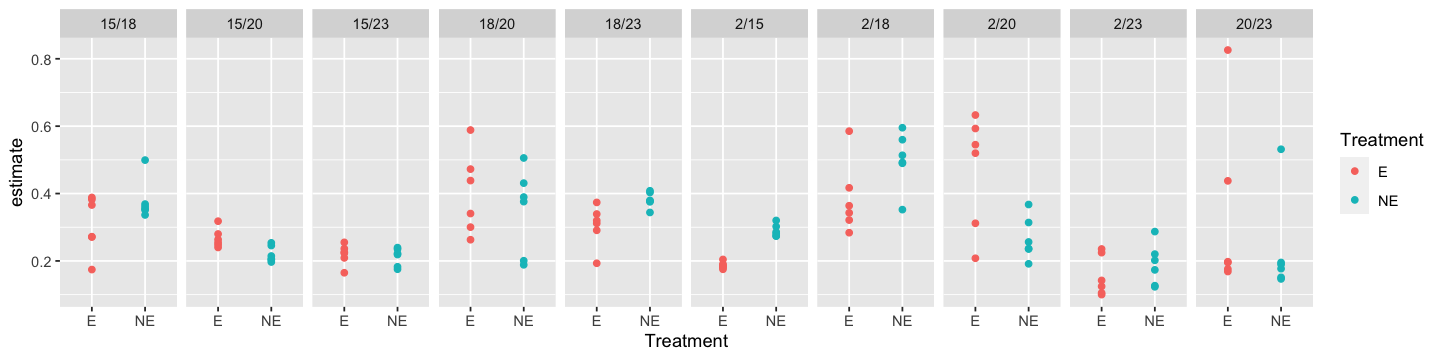

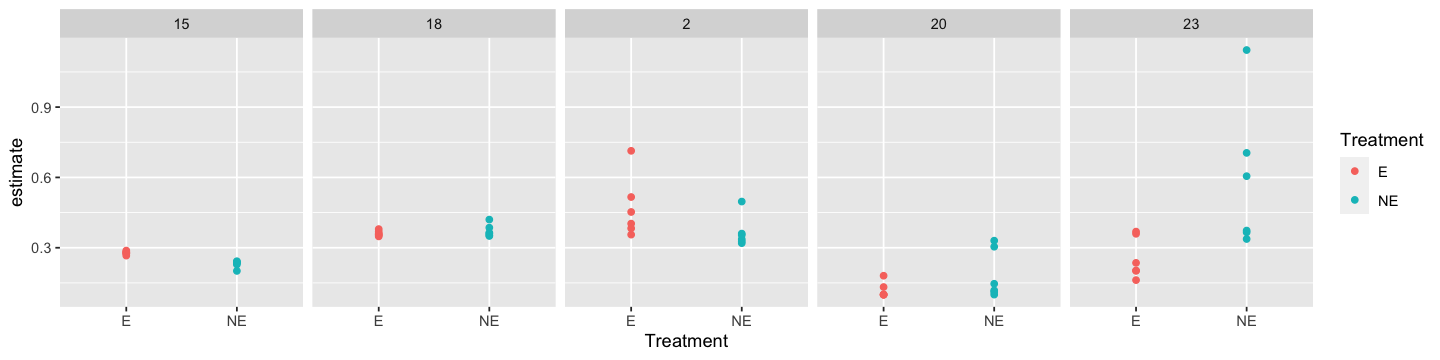

In [99]:
options(repr.plot.width = 12, repr.plot.height = 3)

df_pair %>%
    ggplot(aes(x=Treatment,y=estimate, color = Treatment))+
        geom_point()+
        facet_grid( ~ Id, scales = "free")

df_sp %>%
    ggplot(aes(x=Treatment,y=estimate, color = Treatment))+
        geom_point()+
        facet_grid( ~ Id, scales = "free")

In [ ]:
# #plot params
# options(repr.plot.width = 12, repr.plot.height = 8)
# p1 <- df_sp %>%
#     pivot_longer(c(r,aii)) %>%
#     ggplot(aes(x=Treatment,y = (value)))+
#         geom_point()+
#         facet_grid(name ~ ID, scales = "free")

# p2 <- df_pair %>%
#     ggplot(aes(x=Treatment,y=K))+
#         geom_point()+
#         facet_wrap(~ID, nrow = 2)

# # ggsave(plot = p2,filename = "~/Desktop/K_plots.pdf", height = 4)

# plot_grid(p1,p2, nrow = 2)


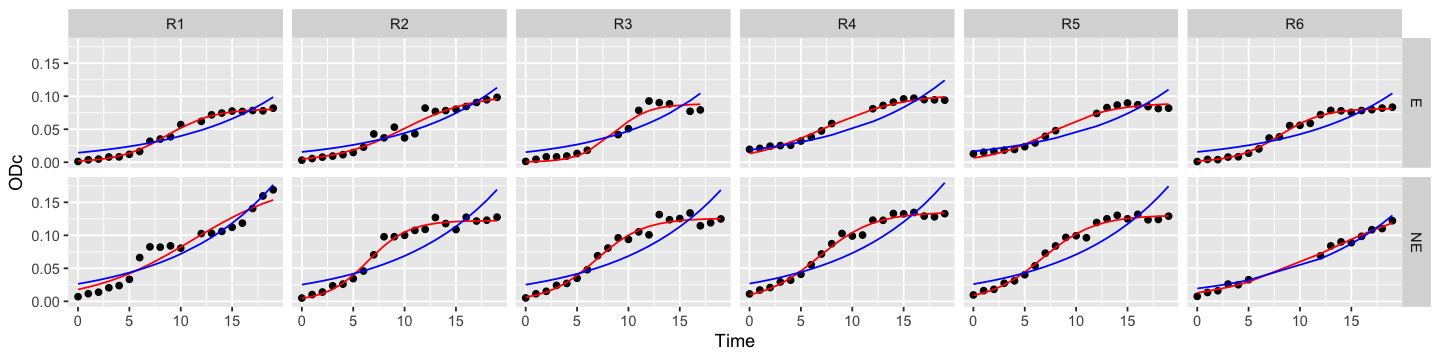

In [101]:
model_fits %>%
    filter(Id == "18/20") %>%
    mutate(log_pred = map(logistic_fit,predict),
           exp_pred = map(exponential_fit,predict)) %>%
    select(-logistic_fit,-exponential_fit) %>%
    unnest(cols = c(data, log_pred, exp_pred)) %>%
    ggplot(aes(x=Time, y = ODc)) +
            geom_point()+
            geom_line(aes(y = log_pred), color = "red") + 
            geom_line(aes(y = exp_pred), color = "blue") + 
            facet_grid(Treatment ~ Replicate)

In [9]:
set.seed(1)

#estimat with bootstrapping
itt <- expand_grid(pair = unique(df_pair$ID), Treatment = unique(df_pair$Treatment)) %>%
    separate(pair, c("OTU_1","OTU_2"), remove = F)

N <- 10000
a_est <- list()

#loop over estimates
for(i in 1:nrow(itt)){
    #get pairs
    OTU1 <- itt$OTU_1[i]
    OTU2 <- itt$OTU_2[i]

    #setup results
    df <- tibble(rep = 1:N, OTU_1 = OTU1, OTU_2 = OTU2,pairs = paste(OTU_1,OTU_2), Treatment = itt$Treatment[i])
    #get individual params
    params_1 <- df_sp %>%
        filter(ID == OTU1, Treatment == itt$Treatment[i])
    params_2 <- df_sp %>%
        filter(ID == OTU2, Treatment == itt$Treatment[i])
    
    #get pairwise params
    params_12 <- df_pair %>%
        filter(OTU_1 == OTU1, OTU_2 == OTU2, Treatment == itt$Treatment[i])

    #get param samples
    r1 <- sample(params_1$r, N, replace = T)
    r2 <- sample(params_2$r, N, replace = T)
        
    a11 <- sample(params_1$aii, N, replace = T)
    a22 <- sample(params_2$aii, N, replace = T)

    Ktot <- sample(params_12$K, N, replace = T)
       
    #estimate
    a <- Ktot
    b <- r1 + r2
    c <- (a11*r2) + (a22*r1) - (Ktot*a11*a22)
    
    d <- as.complex((b^2) - (4*a*c))

    #calculate interaction
    a_1 <- Re((-b + sqrt(d)) / (2*a))
    df$a_1 <- a_1
    
    #check bounds
    df$bot_bound_u <- sqrt(a11*a22)
    df$bot_bound_l <- -sqrt(a11*a22)

    
    df$lb <- pmax(-(r1*a22)/r2, -(r2*a11)/r1)
    df$lb2 <- pmin(-(r1*a22)/r2, -(r2*a11)/r1)


    #are bounds met?
    df$x <- a_1 < df$bot_bound_u 
    df$y <- a_1 > df$lb

    df$z <- df$x & df$y
    
    
    df$ineq_bound <- Ktot > r1/a11
    
    a_est[[i]] <- df
}

In [10]:
feas_df <- bind_rows(a_est) %>%
    filter(z)

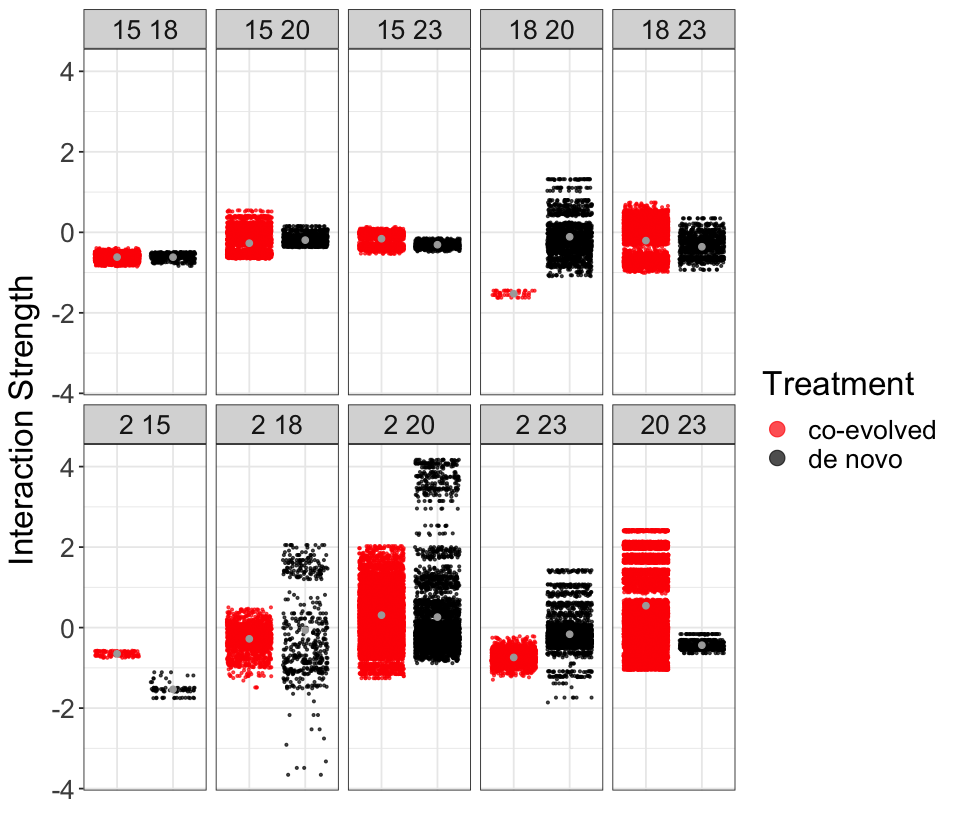

In [11]:
options(repr.plot.width = 8, repr.plot.height = 7)

#plot estimates
p1 <- feas_df %>%
    mutate(Treatment = case_when(Treatment =="E" ~ "co-evolved", Treatment == "NE" ~ "de novo")) %>%
    ggplot(aes(x=Treatment, y=a_1, colour = Treatment))+
        geom_point(position = "jitter", size = 0.5, alpha = 0.7)+
        stat_summary(fun = mean, color = "darkgrey", geom = "point")+
        facet_wrap(~pairs,nrow = 2)+
        ylab("Interaction Strength") +
        xlab("")+
        theme_bw()+
        scale_color_manual(values = c("co-evolved"="Red","de novo"="Black"))+
        theme(text = element_text(size = 20), axis.text.x = element_blank(), axis.ticks.x = element_blank())+
        guides(color = guide_legend(override.aes = list(size = 4)))

suppressWarnings(ggsave("../plots/FigS2_interactions.pdf", p1, height = 7, width = 8))
suppressWarnings(plot(p1))

`summarise()` has grouped output by 'OTU_1', 'OTU_2'. You can override using the `.groups` argument.



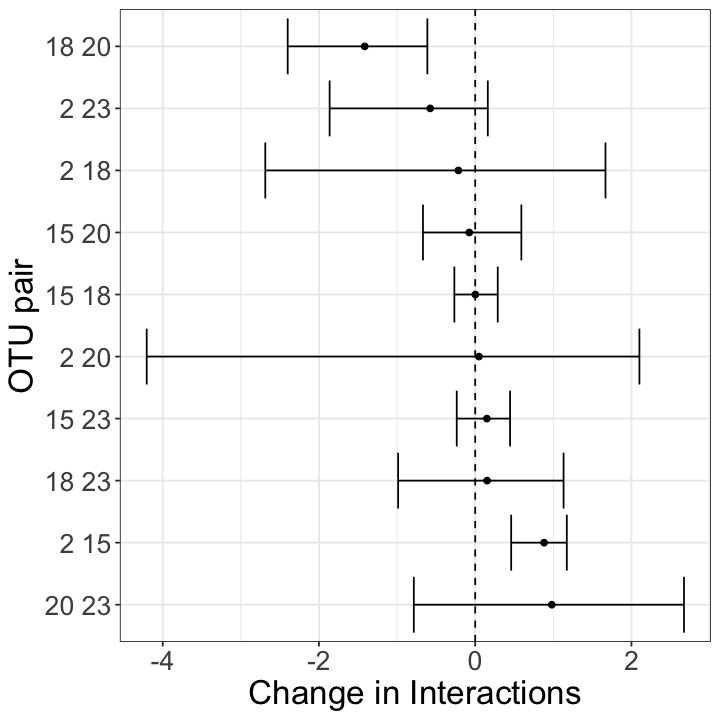

In [12]:
options(repr.plot.width = 6, repr.plot.height = 6)

p2 <- feas_df %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(mean = mean(a_1), Q2.5 = quantile(a_1,0.05),Q97.5 = quantile(a_1,0.95)) %>%
    pivot_wider(names_from = Treatment, values_from = c(mean,Q2.5,Q97.5)) %>%
    mutate(mean = mean_NE - mean_E, Q2.5 = Q2.5_NE - Q97.5_E, Q97.5 = Q97.5_NE - Q2.5_E, ) %>%
    ggplot(aes(y = fct_reorder(paste(OTU_1,OTU_2),mean), x = -mean))+
        geom_point()+
        geom_errorbarh(aes(xmin = -Q2.5, xmax = -Q97.5))+
        geom_vline(xintercept = 0.0,linetype = 2) + 
        xlab("Change in Interactions") + ylab("OTU pair") +
        theme_bw()+
        theme(text = element_text(size = 20)) 
    

p2

# ggsave("~/Desktop/Presentation_figs/Interactions.png", width = 4 , height = 4)

In [13]:
mod <- feas_df %>%
    lmer(a_1 ~ Treatment + (Treatment | pairs) , data = .)

summary(mod)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: a_1 ~ Treatment + (Treatment | pairs)
   Data: .

REML criterion at convergence: 94387.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5061 -0.5385 -0.0386  0.3845  5.9924 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 pairs    (Intercept) 0.3256   0.5706        
          TreatmentNE 0.4492   0.6702   -0.72
 Residual             0.4254   0.6523        
Number of obs: 47525, groups:  pairs, 10

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)  
(Intercept) -0.356123   0.180805  8.851167   -1.97   0.0809 .
TreatmentNE  0.006331   0.212497  8.845647    0.03   0.9769  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
TreatmentNE -0.724

Warning message:
“Missing column names filled in: 'X1' [1]”


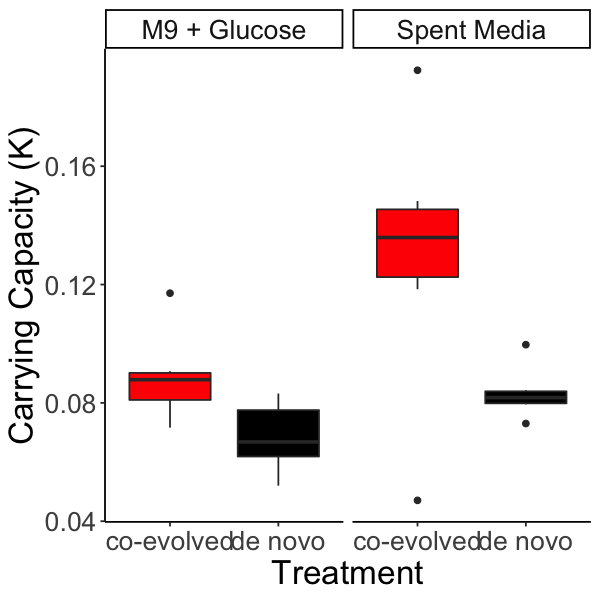

In [21]:
options(repr.plot.width = 5, repr.plot.height = 5)
p1 = read_csv("../data/interactions/Com_LogisticIndivcurves.csv", col_types = cols()) %>%
    separate(pa,into=c("a","Rep"),sep = ":") %>%
    separate(a, into = c("Treatment","Media"), sep = "-") %>%
    mutate(Media = ifelse(Media == "M9", "M9 + Glucose", "Spent Media")) %>%
    mutate(Treatment = recode(Treatment,"CE" = "co-evolved", "CN" = "de novo")) %>%
    ggplot(aes(x=Treatment, y = K, fill = Treatment))+
        geom_boxplot()+
        facet_wrap(~Media)+
        ylab("Carrying Capacity (K)") +
        theme_classic()+
        theme(legend.position = "none", text = element_text(size = 20)) +
        scale_fill_manual(values = c("co-evolved"="Red","de novo"="Black"),label = c("co-evolved","de novo"))

p1

In [24]:
plot_int <- plot_grid(p1,p2, labels = c("a","b"), rel_widths = c(0.6,0.4),label_size = 20)

ggsave("..//plots/Fig3_interactions.pdf", plot_int, height = 5, width = 10)

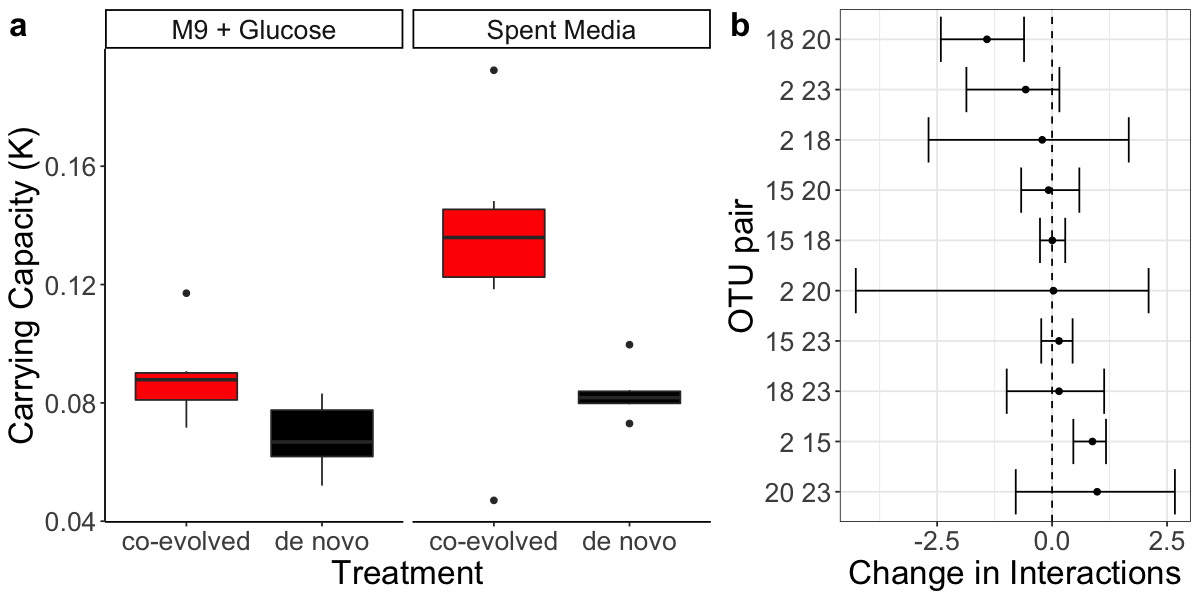

In [26]:
options(repr.plot.width = 10, repr.plot.height = 5)

plot_int 